In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/global/common/software/nersc/cos1.3/cuda/11.3.0'
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
import matplotlib.patches as mpatches
from DifferentiableHOS.Fisher import fisher

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin
sigma_pix=3.6/pix_scale

In [3]:
# Load maps 
kmaps = []
for filename in os.listdir("/pscratch/sd/d/dlan/results_paper/maps/"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/results_paper/maps/', filename), 'rb'))
        kmaps.append(res['kmap'])

2022-04-25 05:45:47.214684: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 05:45:47.567618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38428 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0


In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [5]:
from flowpm.fourier_smoothing import fourier_smoothing
def desc_y1_analysis(kmap,hos=True):
  """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
  ngal = 10 
  pix_scale = field_size / field_npix * 60 
  ngal_per_pix = ngal * pix_scale**2  
  sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix) 
  sigma_pix = 4. / pix_scale  
  kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
  if hos:
      return kmap
  else:
      kmap = fourier_smoothing(kmap,sigma=sigma_pix,resolution=field_npix)
      return kmap
    

In [6]:
bins=tf.linspace(-.1, 1.,8)
rangev=[-.1,1.]
ps=[]
pcounts=[]
l1norm=[]
for i in range(len(kmaps)):
    countsDLL=[]
    l1normDLL=[]
    power_spectrum=[]
    for j in range(len(kmaps[i])):
        kmap = desc_y1_analysis(kmaps[i][j], hos=False)
        ell,p=DHOS.statistics.power_spectrum(kmap[0], field_size,field_npix)
        ell = ell[2:46]
        p = p[2:46]
        # Further reducing the nnumber of points
        ell = rebin(ell, 11)
        p = rebin(p, 11)
        power_spectrum.append(p)
        kmap = tf.expand_dims(desc_y1_analysis(kmaps[i][j]),axis=0)
        counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf_mulscale(kmap,nscales=5,bins=bins)
        counts_FLP=counts_FLP[3:]
        l1norm_FLP=DHOS.statistics.l1norm(kmap,nscales=5, nbins=8, value_range=rangev)
        countsDLL.append(counts_FLP)
        l1normDLL.append(l1norm_FLP)
    pcounts.append(countsDLL)
    l1norm.append(l1normDLL)
    ps.append(power_spectrum)

2022-04-25 05:46:15.942770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-25 05:46:16.542950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


In [7]:
ps= stack(ps, axis=0)
pcounts = stack(pcounts, axis=0)
l1norm=stack(l1norm, axis=0)

In [8]:
f_sky=25/150000

In [9]:
# Computing covariance matrix
cov_ps=np.cov(tf.reshape(tf.stack(ps),[len(ps),11]), rowvar=False)*f_sky
cov_pcounts=np.cov((tf.reshape(tf.stack(pcounts),[len(pcounts),24])), rowvar=False)*f_sky

In [10]:
# def cov_corr_matrix(N,nbins,C):
#     C_corr=(N-nbins-2)/(N-1)*(np.linalg.inv(C))
#     return C_corr
    

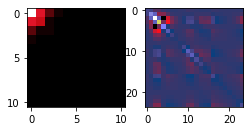

In [11]:
subplot(131)
imshow((cov_ps),cmap='gist_stern')
subplot(132)
imshow(cov_pcounts,cmap='gist_stern')
# subplot(133)


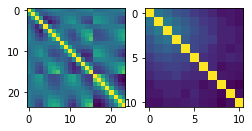

In [12]:
subplot(131)
imshow(np.corrcoef(tf.reshape(tf.stack(pcounts),[len(pcounts),24]).numpy().T))
subplot(132)
imshow(np.corrcoef(tf.reshape(tf.stack(ps),[len(ps),-1]).numpy().T))

In [13]:
#Now, loading the jacobians of the power spectrum 
ps_jac = []
for filename in os.listdir("/pscratch/sd/d/dlan/results_paper/jac_ps"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/results_paper/jac_ps', filename), 'rb'))
        ps_jac.append(res['jac'])

In [14]:
#Now, loading the jacobians of the peak counts
pcounts_jac= []
for filename in os.listdir("/pscratch/sd/d/dlan/results_paper/jac_peakcounts"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/results_paper/jac_peakcounts', filename), 'rb'))
        pcounts_jac.append(res['jac'])


In [15]:
ps_jac= stack(ps_jac, axis=0)
pcounts_jac = stack(pcounts_jac, axis=0)
#l1norm_jac= stack(l1norm_jac, axis=0)

In [16]:
dmu_ps = ps_jac.mean(axis=0)
dmu_pcounts = tf.reshape(stack(pcounts_jac, axis=0),[len(pcounts_jac),24,7]).numpy().mean(axis=0)
#dmu_l1norm = l1norm_jac.mean(axis=0)


In [17]:
# Annnnd let's try to get our first fisher matrix
Fps = dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps
Fpcounts = dmu_pcounts.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

In [19]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$","$A_{IA}$"]
params=[0.2589,0.8159,0.04860,0.9667,0.6774,-1.0,.0]
xyrange=[[0.1,0.5],[0.6,0.9],[0.025,0.1],[0.8,1.2],[0.5,0.8],[-1.1,-0.9],[-1,1]]

In [20]:
# The way to use this:
fid_cosmo = {"$\Omega_c$": 0.2589,
             "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667,
             "$h$": 0.6774,
             "$w_0$": -1.0,
            "$A_{IA}$": 0.}

In [21]:
fisher_object_ps = fisher(Fps, labels,  fid_cosmo)
fisher_object_pcounts = fisher(Fpcounts, labels,  fid_cosmo)

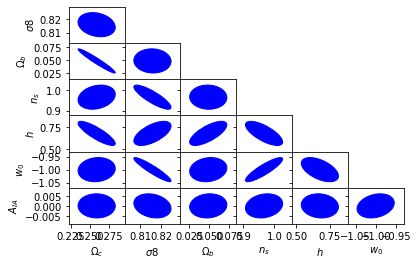

In [22]:
fisher_object_pcounts.corner_plot(color='blue',alpha=1)
#savefig("tes3.png",dpi=150)

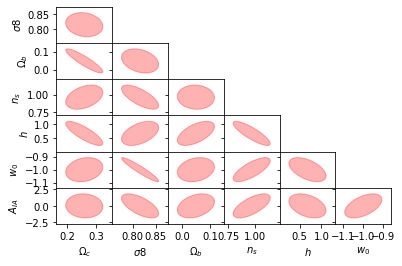

In [23]:
fisher_object_ps.corner_plot(color='red',alpha=0.3)

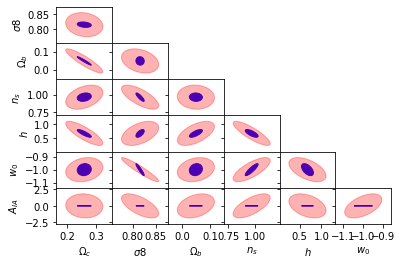

In [24]:
fisher_object_pcounts.corner_plot(color='blue',alpha=1)
fisher_object_ps.corner_plot(color='red',alpha=0.3)